In [1]:
import os.path

import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

real_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

In [3]:
bs = 128
real_dataloader = DataLoader(
    dataset=real_data,
    batch_size=bs
)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=100, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=28*28),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.network(X)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.network(X)

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

G = Generator()
D = Discriminator()

G.to(device)
D.to(device)

Discriminator(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
optimizer_G = torch.optim.Adam(G.parameters(), lr=2e-4)
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4)

bce_loss = torch.nn.BCELoss()
epochs = 200

In [8]:
loss_D_list = []
loss_G_list = []
Dx_list = []
DGz_list = []
iter = 0

def train():
    for epoch in range(epochs):
        print(f"epoch {epoch+1}\n-----------------")
        for i, (X_real, _) in enumerate(real_dataloader):
            
            length = X_real.shape[0]
            
            y_real = torch.ones(length, 1)
            y_fake = torch.zeros(length, 1)

            X_real, y_real, y_fake = X_real.to(device), y_real.to(device), y_fake.to(device)

            # 1 ------------更新Discriminator--------------

            z_batch = torch.randn(length, 100).to(device)
            X_fake = G(z_batch)

            output_real = D(X_real.reshape(length, 28*28))
            loss_real = bce_loss(output_real, y_real)
            output_fake = D(X_fake)
            loss_fake = bce_loss(output_fake, y_fake)

            loss_D = loss_real + loss_fake

            D.zero_grad()
            loss_D.backward()
            optimizer_D.step()

            # 2 -------------更新Generator---------------

            z_batch = torch.randn(length, 100).to(device)
            X_fake = G(z_batch)
            fake_output = D(X_fake)
            loss_G = bce_loss(fake_output, y_real)

            G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            if i % 100 == 0:
                print(f"loss_G: {loss_G.item()}, loss_D: {loss_D.item()}, D(x): {loss_real.item()}, D(G(z)): {loss_fake.item()}")
                loss_G_list.append(loss_G.item())
                loss_D_list.append(loss_D.item())

                Dx_list.append(loss_real.item())
                DGz_list.append(loss_fake.item())
                global iter
                iter += 1
        # 保存最后的权重文件
        torch.save(G.state_dict(), 'model_G.pth')

epoch 1
-----------------
loss_G: 0.7495243549346924, loss_D: 1.363412618637085, D(x): 0.7014787197113037, D(G(z)): 0.6619338989257812
loss_G: 1.6420536041259766, loss_D: 0.585554838180542, D(x): 0.33158689737319946, D(G(z)): 0.25396794080734253
loss_G: 1.7377078533172607, loss_D: 0.9533674716949463, D(x): 0.7124093770980835, D(G(z)): 0.2409580945968628
loss_G: 1.9198389053344727, loss_D: 0.5758934020996094, D(x): 0.3448091149330139, D(G(z)): 0.23108431696891785
loss_G: 1.1511222124099731, loss_D: 1.403984785079956, D(x): 0.9345172047615051, D(G(z)): 0.4694676101207733
epoch 2
-----------------
loss_G: 2.531463384628296, loss_D: 0.2856084704399109, D(x): 0.18910859525203705, D(G(z)): 0.09649986028671265
loss_G: 3.4109373092651367, loss_D: 0.1684371531009674, D(x): 0.1272028535604477, D(G(z)): 0.04123429208993912
loss_G: 3.6132254600524902, loss_D: 0.2388562560081482, D(x): 0.20206165313720703, D(G(z)): 0.03679460659623146
loss_G: 2.2859573364257812, loss_D: 0.4029045104980469, D(x): 0.

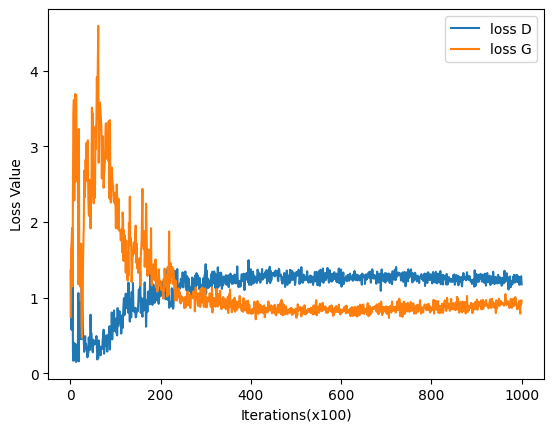

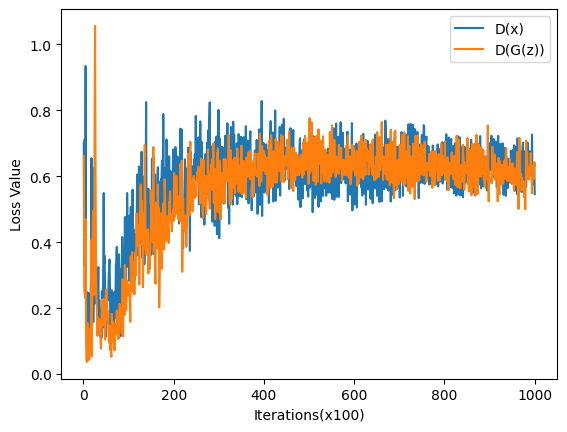

In [9]:
if os.path.exists('model_G.pth'):
    G.load_state_dict(torch.load('model_G.pth'))
else:
    train()

    # 绘制损失图像
    plt.figure()
    loss_D, = plt.plot(range(1, iter+1), loss_D_list)
    loss_G, = plt.plot(range(1, iter+1), loss_G_list)
    plt.legend([loss_D, loss_G], ['loss D', 'loss G'], loc='best')
    plt.xlabel('Iterations(x100)')
    plt.ylabel('Loss Value')
    plt.savefig('loss value')

    # 绘制D(x)和D(G(z))损失图像
    plt.figure()
    Dx, = plt.plot(range(1, iter+1), Dx_list)
    DGz, = plt.plot(range(1, iter+1), DGz_list)
    plt.legend([Dx, DGz], ['D(x)', 'D(G(z))'], loc='best')
    plt.xlabel('Iterations(x100)')
    plt.ylabel('Loss Value')
    plt.savefig('loss D')


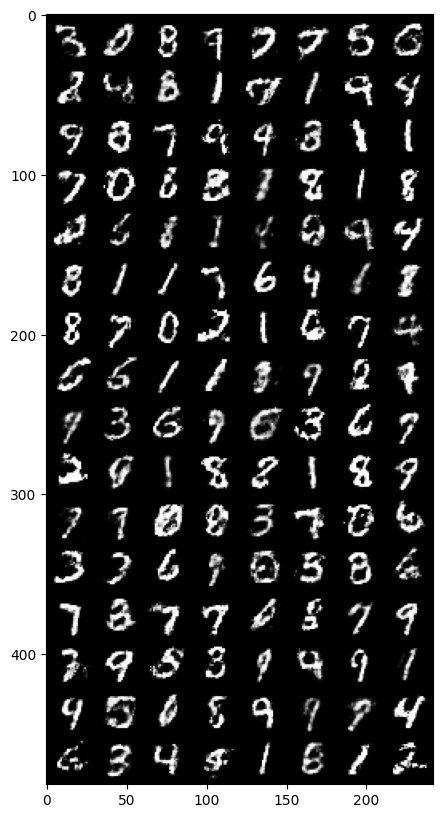

In [10]:
z = torch.randn(bs, 100).to(device)
fake_images = G(z).reshape(bs, 1, 28, 28).cpu().detach()
image_grid = torchvision.utils.make_grid(fake_images)
plt.figure(figsize=(15, 10))
plt.imshow(np.transpose(image_grid, (1, 2, 0)), cmap='gray')